In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from statsmodels.iolib.table import SimpleTable, default_txt_fmt

In [2]:
# Lecture des données
data = pd.read_csv('data/flandreau_jobst_internationalcurrencies_data.txt', encoding='cp1252', skiprows=9, header=0, sep='\t')

In [3]:
# Commençons par créer un fichier attributes en ne gardant que les éléments par pays puis supprimant les lignes qui se répètent
attributes = data[["country_A", "gold", "colony", "debtburden", "rlong", "rshort1900", "rshort1890", "rgdp", "rgdpcap", "poldemo", "coverage"]]
# Sort the dataframe to ensure rows with colony=1 come first
attributes = attributes.sort_values(by=["country_A", "colony"], ascending=[True, False])
# Drop duplicates, keeping the first row (colony=1 will be kept if present)
attributes = attributes.drop_duplicates(subset="country_A", keep="first").reset_index(drop=True)
attributes = attributes.rename(columns={"colony": "is_colonized"})

# Récupérons aussi le nombre de colonies
nb_colonies = data.groupby("country_B")["colony"].sum().reset_index()
nb_colonies = nb_colonies.rename(columns={"colony": "has_colonies"})
attributes = nb_colonies.merge(attributes, left_on="country_B", right_on="country_A", how="left")
attributes = attributes.drop(columns=['country_A'])
attributes = attributes.rename(columns={"country_B": "country"})

In [4]:
country_mapping = {
    "ARG": "Argentina",
    "AUS": "Australia",
    "AUH": "United Arab Emirates",
    "BEL": "Belgium",
    "BRA": "Brazil",
    "CAN": "Canada",
    "CEY": "Ceylon",
    "CHE": "Switzerland",
    "CHL": "Chile",
    "CHN": "China",
    "COL": "Colombia",
    "CUB": "Cuba",
    "DEU": "Germany",
    "DNK": "Denmark",
    "ECU": "Ecuador",
    "EGY": "Egypt",
    "ESP": "Spain",
    "FIN": "Finland",
    "FRA": "France",
    "GBR": "United Kingdom",
    "GRC": "Greece",
    "HKG": "Hong Kong",
    "ICH": "Sandwich Islands",
    "IND": "India",
    "ITA": "Italy",
    "JAV": "Java",
    "JPN": "Japan",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NOR": "Norway",
    "NZL": "New Zealand",
    "OTT": "Ottoman Empire",
    "PER": "Peru",
    "PHL": "Philippines",
    "PRT": "Portugal",
    "PRS": "Persia",
    "ROM": "Romania",
    "RUS": "Russia",
    "SER": "Serbia",
    "SGP": "Singapore",
    "SIA": "Siam",
    "SWE": "Sweden",
    "URY": "Uruguay",
    "USA": "United States",
    "VEN": "Venezuela"}

attributes["country"] = attributes["country"].map(country_mapping)

In [5]:
data.head(1).style.hide(axis="index")

country_A,country_B,quote1890,quote1900,quote1910,colony,dist,bitrade,gold,debtburden,rlong,rshort1900,rshort1890,rgdp,rgdpcap,poldemo,coverage,gold_B,debtburden_B,rlong_B,rshort1900_B,rshort1890_B,rgdp_B,rgdpcap_B,poldemo_B
ARG,AUH,0,0,0,0,9.374816,5909.760000,1,6.844985,7.010000,7.060000,9.330000,16.375360,7.921540,0.300000,1.945910,1,5.222065,4.010000,4.580000,4.480000,18.143680,7.393880,0.870000


In [6]:
attributes.head(1).style.hide(axis="index")

country,has_colonies,gold,is_colonized,debtburden,rlong,rshort1900,rshort1890,rgdp,rgdpcap,poldemo,coverage
Argentina,0,1,0,6.844985,7.010000,7.060000,9.330000,16.375360,7.921540,0.300000,1.945910


# Première approche
***Description de la structure du graph ?***

Il faut d'abord bien préciser la signification des données : un lien allant de $A$ vers $B$ signifie que le pays $B$ possède un marché des changes intégrant la devise du pays $A$. En l'absence de tout autre lien, cela signifie qu'il est nécessaire de passer par le pays $B$ pour échanger la devise du pays $A$, c'est-à-dire que le pays $A$ est dépendant du pays $B$ pour ses échanges extérieurs.

_Je pense que c'est plus compliqué que cela, dès lors que le pays A a lui même un marché des changes domestique, sur lequel on peut raisonnablement penser qu'une des monnaies qui est échangée est la sienne. De ce point de vue, c'est plutôt le pays $B$ qui dépends du pays $A$. Plus un pays à un nombre important de liens pointant vers lui, plus il a accès à une diversité importante de monnaie, sans avoir besoin de recourir à un marché d'un pays tiers. Mais du coup, un pays qui n'a qu'un seul lien pointant vers lui, comme l'Autralie par exemple, n'a accès qu'à une seule devise depuis son territoire. Un pays qui n'a aucun lien pointant vers lui n'a accès à aucune devise._

In [7]:
# Création d'un graph orienté avec la variable 1900 (possible de pondérer le graph pour utiliser les 3 ? Ou de faire avec le commerce ?)
graph_change_1900 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1900"] == 1:
        graph_change_1900.add_edge(row["country_A"], row["country_B"])

In [8]:
n = graph_change_1900.number_of_nodes()
L = graph_change_1900.number_of_edges()
density = L/(n*(n-1))
print(f"Nombre de sommets : {n}")
print(f"Nombre d'arêtes : {L}")
print(f"Densité : {density:.4f}")

Nombre de sommets : 45
Nombre d'arêtes : 218
Densité : 0.1101


On constate d'emblée que le réseau est très peu dense, avec seulement 218 liens sur les $45*44=1980$ possibles, ce qui correspond à une densité de 0.11 : ceci indique que la majorité des pays ne sont pas directement connectés sur le marché des changes, autrement dit, que celui-ci fonctionne de manière centralisée, ou que de nombreux pays ne participent pas aux échanges internationaux.

In [9]:
isolates = list(nx.isolates(graph_change_1900))
print(f"Proportion de pays isolés : {len(isolates) / n:.0f}")

no_incoming = [node for node in graph_change_1900.nodes() if graph_change_1900.in_degree(node) == 0]
no_incoming_share = len(no_incoming) / n if n > 0 else 0
print(f"Proportion de pays  sans lien entrant : {100*no_incoming_share:.1f} %")

bidir_edges = sum(1 for u, v in graph_change_1900.edges() if graph_change_1900.has_edge(v, u))
total_edges = graph_change_1900.number_of_edges()
unidir_edges = total_edges - bidir_edges
country_links = unidir_edges + (bidir_edges / 2)
bidir_share = (bidir_edges / 2) / country_links
print(f"Proportion de liens qui ne sont pas réciproques : {100*(1-bidir_share):.1f} %")

print(f"La réciprocité moyenne vaut {nx.reciprocity(graph_change_1900):.3f}")

Proportion de pays isolés : 0
Proportion de pays  sans lien entrant : 44.4 %
Proportion de liens qui ne sont pas réciproques : 72.5 %
La réciprocité moyenne vaut 0.431


On ne trouve aucun pays isolé, ce qui écarte l'hypothèse de pays ne participant pas aux échanges internationaux. En revanche, 44,4 % des pays ne sont destinataires d'aucun lien, c'est-à-dire qu'ils doivent utiliser des marchés étrangers pour échanger leur monnaie nationale.

_A noter que c'est clairement un effet de la structure du dataset, qui est construit sous forme d'une edgelist (un peu développée, certes...). Mais un pays isolé n'apparaitrait pas ici. Bon, en même temps, on parle ici de devise, donc à un moment ou un autre ça doit puvoir être écheangable._

Si l'on s'intéresse aux liens entre pays sans considérer leur direction, mais seulement leur caractère unilatéral ou réciproque, on constate que 72,5 % des pays n'entretiennent aucun lien réciproque. _Ici je pense qu'il y a une confusion entre les edges et les nodes_

In [10]:
undirected = graph_change_1900.to_undirected()
print(f"Is the graph connected? {nx.is_connected(undirected)}")
print(f"Average shortest path length: {nx.average_shortest_path_length(undirected):.2f}")

Is the graph connected? True
Average shortest path length: 1.83


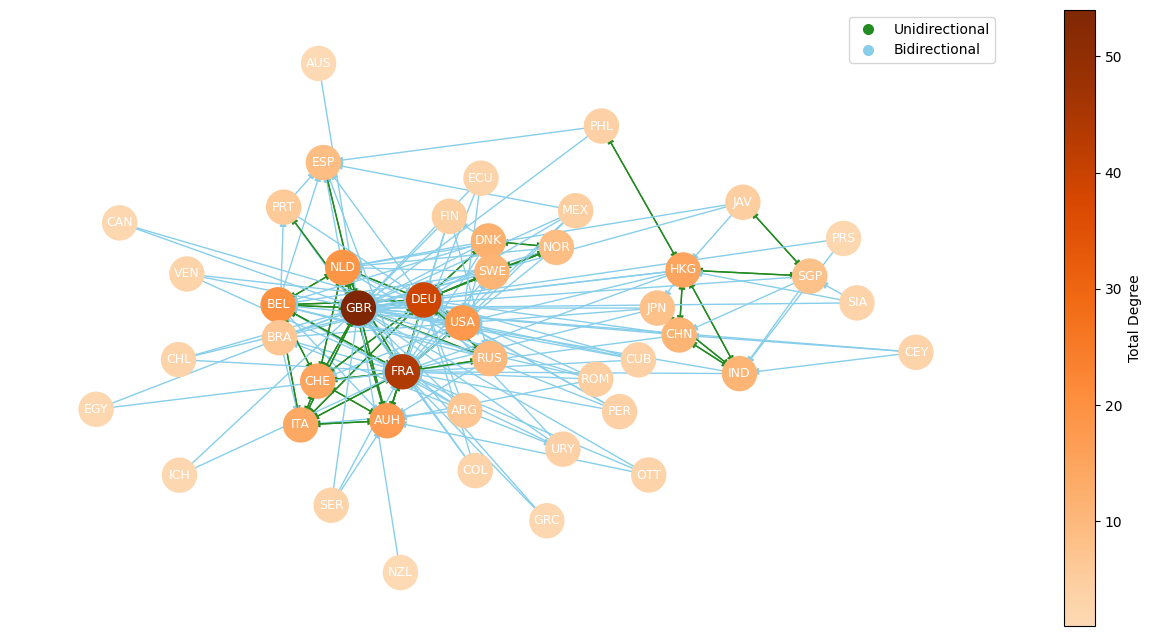

In [11]:
def truncate_colormap(cmap_name, min_val=0.2, max_val=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc", cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

trunc_oranges = truncate_colormap("Oranges", 0.2, 1.0)

# Determine edge colors
edge_colors = []
for u, v in graph_change_1900.edges():
    if graph_change_1900.has_edge(v, u):
        edge_colors.append("forestgreen")  # reciprocal
    else:
        edge_colors.append("skyblue")  # unidirectional

# Compute node colors based on total degree (in-degree + out-degree)
degrees = dict(graph_change_1900.degree())
node_colors = [degrees[node] for node in graph_change_1900.nodes()]

# Draw graph
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(graph_change_1900, seed=43)

nodes = nx.draw_networkx_nodes(
    graph_change_1900,
    pos,
    node_size=600,
    node_color=node_colors,
    cmap=trunc_oranges)

edges = nx.draw_networkx_edges(
    graph_change_1900,
    pos,
    edge_color=edge_colors)

labels = nx.draw_networkx_labels(graph_change_1900, pos, font_size=9, font_color="white")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=9, label='Unidirectional'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=9, label='Bidirectional')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.colorbar(nodes, label="Total Degree")
plt.axis("off")
plt.show()

Une représentation graphique fait apparaître :
- Un marché des changes très intégré entre l'Europe et les Etats-Unis, rassemblant une dizaine de pays (GBR, FRA, DEU, USA notamment)
- Un marché des changes secondaires en Asie, rassemblant une demi-douzaine de pays (HKG, SGP, CHN, IND notamment)
- Un relatif isolement des autres pays, qui entretiennent des liens unilatéraux avec quelques pays appartenants aux groupes précédents

(On pourrait utiliser le nombre de devises échangées plutôt que le nombre de liens pour la coloration.)

_Sauf que l'on a pas cette info dans le dataset, juste le volume du commerce..._

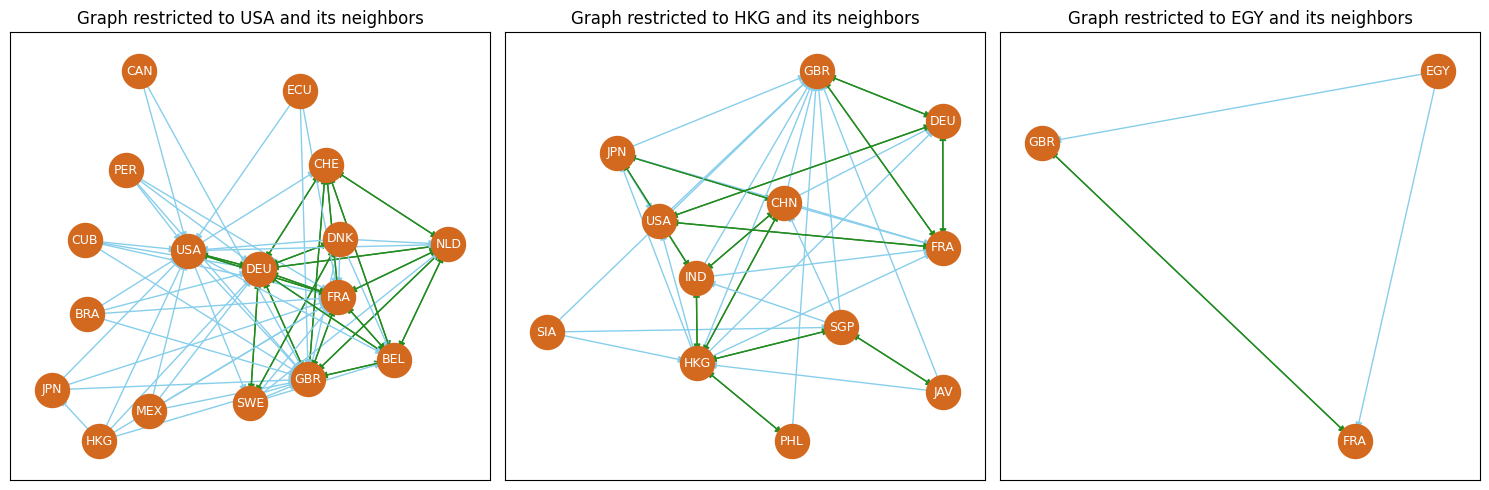

In [12]:
countries = ["USA", "HKG", "EGY"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, country_B in enumerate(countries):
    # Get the nodes related to country_B
    neighbors = list(graph_change_1900.neighbors(country_B))
    predecessors = list(graph_change_1900.predecessors(country_B))
    nodes_involved = [country_B] + neighbors + predecessors
    subgraph = graph_change_1900.subgraph(nodes_involved)
    restricted_graph = nx.DiGraph(subgraph)

    edge_colors = []
    for u, v in restricted_graph.edges():
        if restricted_graph.has_edge(v, u):
            edge_colors.append("forestgreen")  # reciprocal
        else:
            edge_colors.append("skyblue")  # unidirectional

    pos = nx.spring_layout(restricted_graph)
    ax = axes[i]
    nx.draw_networkx_nodes(restricted_graph, pos, node_size=600, node_color="chocolate", ax=ax)
    nx.draw_networkx_edges(restricted_graph, pos, edge_color=edge_colors, ax=ax)
    nx.draw_networkx_labels(restricted_graph, pos, font_size=9, font_color="white", ax=ax)
    ax.set_title(f"Graph restricted to {country_B} and its neighbors")

plt.tight_layout()
plt.show()

On peut faire apparaître les marchés intégrés en restreignant le graph aux liens réciproques ou en recherchant les cliques...

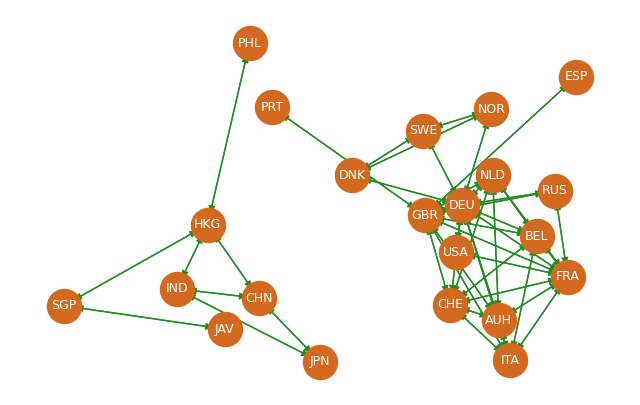

In [52]:
graph_change_1900 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1900"] == 1:
        graph_change_1900.add_edge(row["country_A"], row["country_B"])

# Filter for reciprocal edges
reciprocal_edges = [(u, v) for u, v in graph_change_1900.edges() if graph_change_1900.has_edge(v, u)]
# Get nodes involved in reciprocal edges
nodes_with_reciprocal_edges = set(u for u, v in reciprocal_edges) | set(v for u, v in reciprocal_edges)

plt.figure(figsize=(8, 5))
pos = nx.spring_layout(graph_change_1900, seed=42)
graph_filtered = graph_change_1900.subgraph(nodes_with_reciprocal_edges)

nx.draw_networkx_nodes(graph_filtered, pos, node_size=600, node_color="chocolate")
nx.draw_networkx_edges(graph_filtered, pos, edgelist=reciprocal_edges, edge_color="forestgreen")
nx.draw_networkx_labels(graph_filtered, pos, font_size=9, font_color="white")

plt.axis("off")
plt.savefig("bidire_graph.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

plt.savefig("bidire_graph.png", format="png", dpi=300, bbox_inches="tight")

In [14]:
# On peut essayer de formaliser en recherchant des cliques
undirected_graph = graph_change_1900.to_undirected()
cliques = list(nx.find_cliques(undirected_graph ))
largest_cliques = sorted(cliques, key=len, reverse=True)[:1]
print(f"Plus grande clique : {largest_cliques[0]}")

Plus grande clique : ['GBR', 'FRA', 'DEU', 'BEL', 'NLD', 'USA', 'DNK', 'SWE']


In [47]:
# On peut aussi chercher les cliques billatérales
# On supprime les doublons de reciprocal_edges
reciprocal_edges_unique = set(tuple(sorted(edge)) for edge in reciprocal_edges)
reciprocal_graph = nx.Graph()
reciprocal_graph.add_edges_from(reciprocal_edges_unique)
reciprocal_cliques = list(nx.find_cliques(reciprocal_graph))
largest_reciprocal_cliques = sorted(reciprocal_cliques, key=len, reverse=True)[:1]
print(f"Plus grande clique : {largest_reciprocal_cliques[0]}")

Plus grande clique : ['DEU', 'NLD', 'FRA', 'CHE', 'ITA', 'GBR', 'AUH']


In [48]:
reciprocal_cliques

[['ARG', 'URY'],
 ['JPN', 'CHN', 'IND'],
 ['JPN', 'USA'],
 ['DEU', 'PRT', 'GBR', 'FRA'],
 ['DEU', 'NLD', 'DNK', 'SWE', 'NOR'],
 ['DEU', 'NLD', 'SWE', 'USA'],
 ['DEU', 'NLD', 'FRA', 'CHE', 'ITA', 'GBR', 'AUH'],
 ['DEU', 'NLD', 'FRA', 'CHE', 'ITA', 'GBR', 'BEL'],
 ['DEU', 'NLD', 'FRA', 'CHE', 'ITA', 'USA'],
 ['DEU', 'NLD', 'FRA', 'RUS', 'AUH', 'GBR'],
 ['DEU', 'ESP', 'GBR', 'FRA'],
 ['HKG', 'CHN', 'IND'],
 ['HKG', 'USA'],
 ['HKG', 'SGP']]

In [15]:
out_degree = graph_change_1900.out_degree()
in_degree = graph_change_1900.in_degree()

out_degree_centrality = nx.out_degree_centrality(graph_change_1900)
in_degree_centrality = nx.in_degree_centrality(graph_change_1900)
betweenness_centrality = nx.betweenness_centrality(graph_change_1900)
eigenvector_centrality = nx.eigenvector_centrality(graph_change_1900)

df = pd.DataFrame({
    "Country": [node for node, _ in out_degree],
    "Out-Degree": [degree for _, degree in out_degree],
    "In-Degree": [degree for _, degree in in_degree],
    "Out-Degree Centrality": [out_degree_centrality.get(node, 0) for node, _ in out_degree],
    "In-Degree Centrality": [in_degree_centrality.get(node, 0) for node, _ in in_degree],
    "Betweenness Centrality": [betweenness_centrality.get(node, 0) for node, _ in out_degree],
    "Eigenvector Centrality": [eigenvector_centrality.get(node, 0) for node, _ in out_degree]
})

df["In / Out ratio"] = df["In-Degree Centrality"] / df["Out-Degree Centrality"]
df = df[[*df.columns[:df.columns.get_loc("In-Degree Centrality")+1], "In / Out ratio", *df.columns[df.columns.get_loc("In-Degree Centrality")+1:].drop("In / Out ratio")]]

df_sorted = df.sort_values(by="Betweenness Centrality", ascending=False)
df_sorted.style.hide(axis="index").format({
    "Out-Degree": "{:.0f}",
    "In-Degree": "{:.0f}",
    "Out-Degree Centrality": "{:.3f}",
    "In-Degree Centrality": "{:.3f}",
    "Betweenness Centrality": "{:.3f}",
    "Average Centrality": "{:.3f}",
    "In / Out ratio": "{:.3f}",
    "Eigenvector Centrality": "{:.3f}",
})

Country,Out-Degree,In-Degree,Out-Degree Centrality,In-Degree Centrality,In / Out ratio,Betweenness Centrality,Eigenvector Centrality
GBR,10,44,0.227,1.000,4.400,0.115,0.386
DEU,13,26,0.295,0.591,2.000,0.104,0.365
FRA,9,35,0.205,0.795,3.889,0.046,0.386
HKG,9,6,0.205,0.136,0.667,0.023,0.000
DNK,9,3,0.205,0.068,0.333,0.023,0.065
USA,7,11,0.159,0.250,1.571,0.012,0.105
IND,5,6,0.114,0.136,1.200,0.007,0.000
CHN,6,5,0.136,0.114,0.833,0.006,0.000
SGP,5,3,0.114,0.068,0.600,0.005,0.000
NLD,7,12,0.159,0.273,1.714,0.004,0.328


In [16]:
pearson_corr = df['In-Degree'].corr(df['Out-Degree'])
print(f"Corrélation entre les centralités entrantes et sortantes : {pearson_corr:.4f}")

Corrélation entre les centralités entrantes et sortantes : 0.7104


... ou en étudiant la centralité.

La **centralité intermédiaire** fait ressortir quelques marchés constituant des points de passage obligés : GBR et DEU, ainsi dans une moindre mesure que FRA, HKG et DNK.

Le ratio entre les **centralités entrantes et sortantes**, c'est-à-dire entre le nombre de devises échangées localement par un pays, et le nombre de pays échangeant sa propre devise, permet de distinguer des situations plus contrastées.
- Les pays colonisateurs : GBR, FRA et ESP, dont la centralité sortante est très supérieure à la centralité entrante, sans doute parce qu'ils entretiennent des liens unilatéraux avec leurs colonnies et des liens bilatéraux avec les autres pays développés.
- Les pays développés : DEU, IT, USA, etc., dont les centralités entrantes et sortantes sont relativement proches, sans doute parce qu'ils entretiennent surtout des liens bilatéraux entre eux.
- Les pays périphériques / dépendants, qui n'ont aucun lien entrant.

La **centralité vectorielle** n'apporte rien par rapport aux analyses précédentes, elle oppose seulement les pays intégrés aux autres.

_Pas certain là non plus sur la centralité vectorielle, qui semble quand même écarter beaucoup le cas des USA par exemple, bien en dessous de l'Italie, de l'Autriche, la Belgique ou la Hollande..._

In [17]:
# Jetons un oeil à la transitivité
print(f"La transitivité globale est de {nx.average_clustering(graph_change_1900):.3f}")
print(f"La transitivité moyenne est de {nx.transitivity(graph_change_1900):.3f}")

print('La transitivité locale de chaque pays est : ')
for node, coeff in sorted(nx.clustering(graph_change_1900).items(), key=lambda x: x[1]):
    print(f"{node}: {coeff:.3f}")

La transitivité globale est de 0.653
La transitivité moyenne est de 0.700
La transitivité locale de chaque pays est : 
AUS: 0.000
NZL: 0.000
GBR: 0.137
FRA: 0.201
DEU: 0.263
HKG: 0.297
USA: 0.348
PHL: 0.400
IND: 0.433
SGP: 0.442
CHN: 0.481
CAN: 0.500
JAV: 0.500
PRS: 0.500
ESP: 0.571
BEL: 0.582
NLD: 0.588
BRA: 0.595
JPN: 0.615
AUH: 0.638
ARG: 0.643
DNK: 0.643
CEY: 0.667
SIA: 0.667
PRT: 0.714
SWE: 0.740
URY: 0.750
MEX: 0.750
ITA: 0.771
FIN: 0.800
NOR: 0.818
ECU: 0.833
RUS: 0.845
CHE: 0.867
CUB: 0.917
PER: 0.917
ROM: 0.950
CHL: 1.000
COL: 1.000
EGY: 1.000
GRC: 1.000
ICH: 1.000
OTT: 1.000
SER: 1.000
VEN: 1.000


La transitivité ne semble pas très éclairante.

## Bonus

**Est-ce qu'on voit des choses différentes en prenant une autre année ?**


In [18]:
# Création d'un graph orienté avec la variable 18900 (possible de pondérer le graph pour utiliser les 3 ? Ou de faire avec le commerce ?)
graph_change_1890 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1890"] == 1:
        graph_change_1890.add_edge(row["country_A"], row["country_B"])

In [19]:
n = graph_change_1890.number_of_nodes()
L = graph_change_1890.number_of_edges()
density = L/(n*(n-1))
print(f"Nombre de sommets : {n}")
print(f"Nombre d'arêtes : {L}")
print(f"Densité : {density:.4f}")

Nombre de sommets : 45
Nombre d'arêtes : 194
Densité : 0.0980


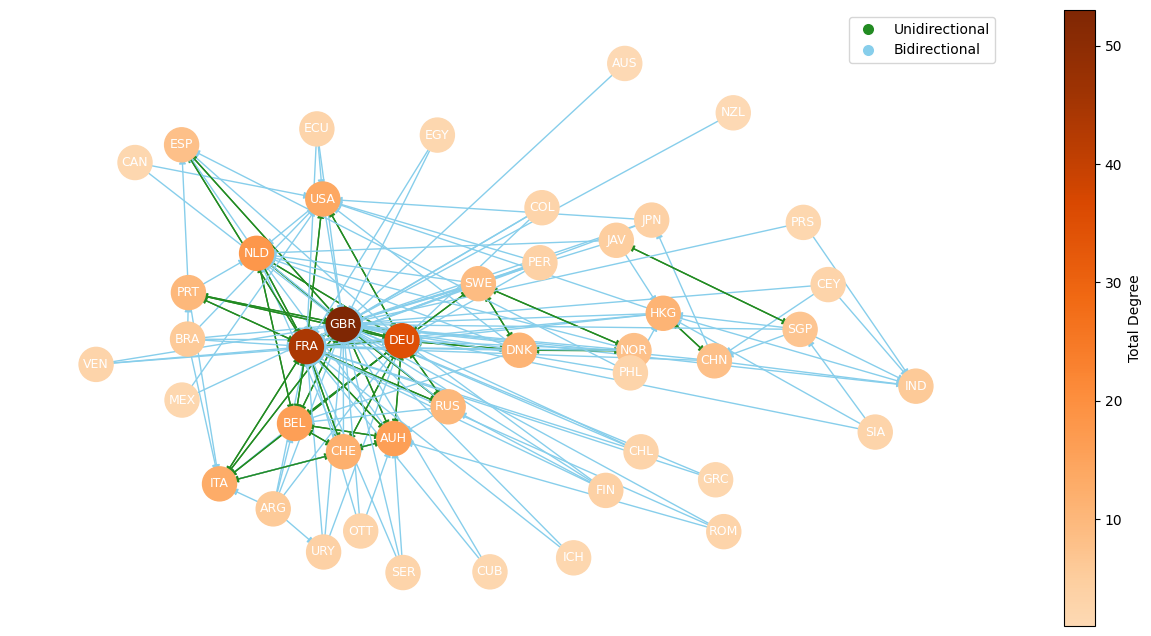

In [20]:
def truncate_colormap(cmap_name, min_val=0.2, max_val=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc", cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

trunc_oranges = truncate_colormap("Oranges", 0.2, 1.0)

# Determine edge colors
edge_colors = []
for u, v in graph_change_1890.edges():
    if graph_change_1890.has_edge(v, u):
        edge_colors.append("forestgreen")  # reciprocal
    else:
        edge_colors.append("skyblue")  # unidirectional

# Compute node colors based on total degree (in-degree + out-degree)
degrees = dict(graph_change_1890.degree())
node_colors = [degrees[node] for node in graph_change_1890.nodes()]

# Draw graph
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(graph_change_1890, seed=43)

nodes = nx.draw_networkx_nodes(
    graph_change_1890,
    pos,
    node_size=600,
    node_color=node_colors,
    cmap=trunc_oranges)

edges = nx.draw_networkx_edges(
    graph_change_1890,
    pos,
    edge_color=edge_colors)

labels = nx.draw_networkx_labels(graph_change_1890, pos, font_size=9, font_color="white")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=9, label='Unidirectional'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=9, label='Bidirectional')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.colorbar(nodes, label="Total Degree")
plt.axis("off")
plt.show()

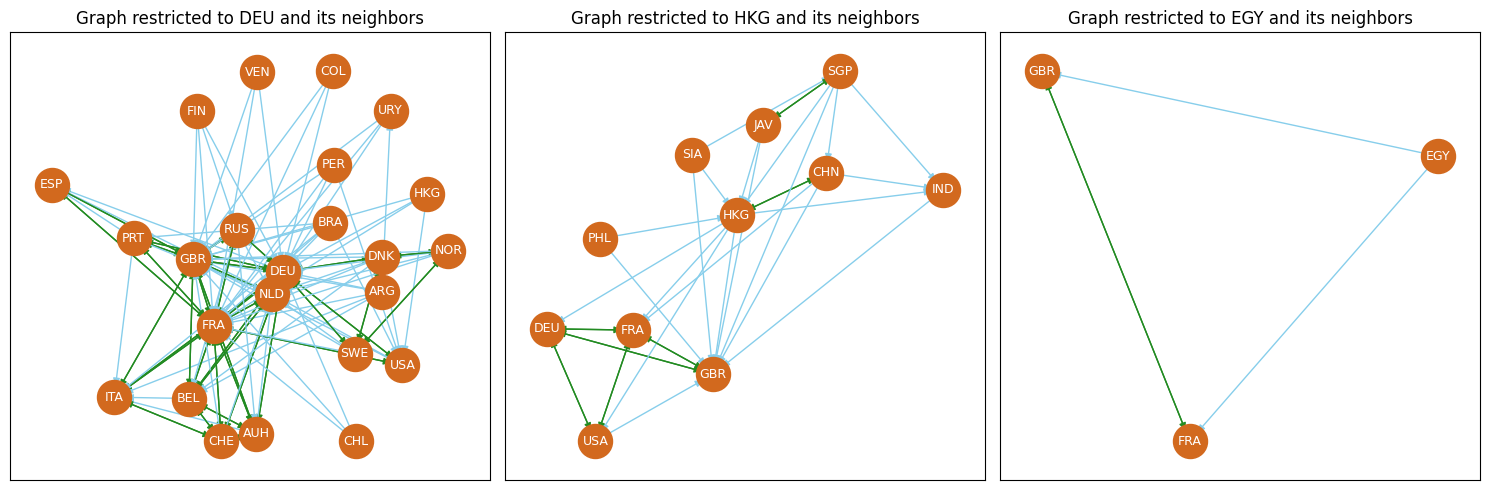

In [21]:
countries = ["DEU", "HKG", "EGY"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, country_B in enumerate(countries):
    # Get the nodes related to country_B
    neighbors = list(graph_change_1890.neighbors(country_B))
    predecessors = list(graph_change_1890.predecessors(country_B))
    nodes_involved = [country_B] + neighbors + predecessors
    subgraph = graph_change_1890.subgraph(nodes_involved)
    restricted_graph = nx.DiGraph(subgraph)

    edge_colors = []
    for u, v in restricted_graph.edges():
        if restricted_graph.has_edge(v, u):
            edge_colors.append("forestgreen")  # reciprocal
        else:
            edge_colors.append("skyblue")  # unidirectional

    pos = nx.spring_layout(restricted_graph)
    ax = axes[i]
    nx.draw_networkx_nodes(restricted_graph, pos, node_size=600, node_color="chocolate", ax=ax)
    nx.draw_networkx_edges(restricted_graph, pos, edge_color=edge_colors, ax=ax)
    nx.draw_networkx_labels(restricted_graph, pos, font_size=9, font_color="white", ax=ax)
    ax.set_title(f"Graph restricted to {country_B} and its neighbors")

plt.tight_layout()
plt.show()

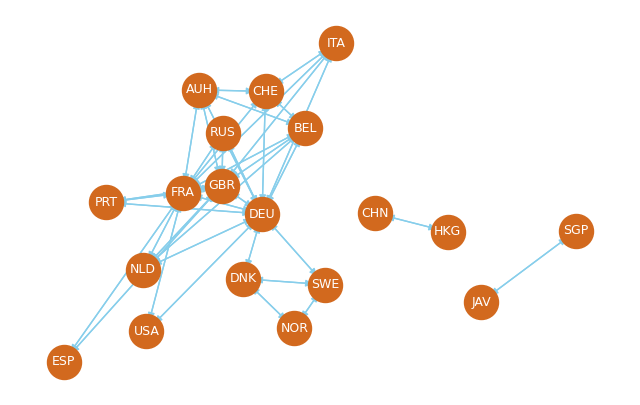

In [22]:
graph_change_1890 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1890"] == 1:
        graph_change_1890.add_edge(row["country_A"], row["country_B"])

# Filter for reciprocal edges
reciprocal_edges = [(u, v) for u, v in graph_change_1890.edges() if graph_change_1890.has_edge(v, u)]
# Get nodes involved in reciprocal edges
nodes_with_reciprocal_edges = set(u for u, v in reciprocal_edges) | set(v for u, v in reciprocal_edges)

plt.figure(figsize=(8, 5))
pos = nx.spring_layout(graph_change_1890, seed=42)
graph_filtered = graph_change_1890.subgraph(nodes_with_reciprocal_edges)

nx.draw_networkx_nodes(graph_filtered, pos, node_size=600, node_color="chocolate")
nx.draw_networkx_edges(graph_filtered, pos, edgelist=reciprocal_edges, edge_color="skyblue")
nx.draw_networkx_labels(graph_filtered, pos, font_size=9, font_color="white")

plt.axis("off")
plt.show()

In [23]:
out_degree = graph_change_1890.out_degree()
in_degree = graph_change_1890.in_degree()

out_degree_centrality = nx.out_degree_centrality(graph_change_1890)
in_degree_centrality = nx.in_degree_centrality(graph_change_1890)
betweenness_centrality = nx.betweenness_centrality(graph_change_1890)
eigenvector_centrality = nx.eigenvector_centrality(graph_change_1890)

df = pd.DataFrame({
    "Country": [node for node, _ in out_degree],
    "Out-Degree": [degree for _, degree in out_degree],
    "In-Degree": [degree for _, degree in in_degree],
    "Out-Degree Centrality": [out_degree_centrality.get(node, 0) for node, _ in out_degree],
    "In-Degree Centrality": [in_degree_centrality.get(node, 0) for node, _ in in_degree],
    "Betweenness Centrality": [betweenness_centrality.get(node, 0) for node, _ in out_degree],
    "Eigenvector Centrality": [eigenvector_centrality.get(node, 0) for node, _ in out_degree]
})

df["In / Out ratio"] = df["In-Degree Centrality"] / df["Out-Degree Centrality"]
df = df[[*df.columns[:df.columns.get_loc("In-Degree Centrality")+1], "In / Out ratio", *df.columns[df.columns.get_loc("In-Degree Centrality")+1:].drop("In / Out ratio")]]

df_sorted = df.sort_values(by="Betweenness Centrality", ascending=False)
df_sorted.style.hide(axis="index").format({
    "Out-Degree": "{:.0f}",
    "In-Degree": "{:.0f}",
    "Out-Degree Centrality": "{:.3f}",
    "In-Degree Centrality": "{:.3f}",
    "Betweenness Centrality": "{:.3f}",
    "Average Centrality": "{:.3f}",
    "In / Out ratio": "{:.3f}",
    "Eigenvector Centrality": "{:.3f}",
})

Country,Out-Degree,In-Degree,Out-Degree Centrality,In-Degree Centrality,In / Out ratio,Betweenness Centrality,Eigenvector Centrality
GBR,9,44,0.205,1.000,4.889,0.111,0.405
DEU,13,22,0.295,0.500,1.692,0.093,0.378
FRA,11,33,0.250,0.750,3.000,0.065,0.405
DNK,8,3,0.182,0.068,0.375,0.012,0.062
HKG,6,5,0.136,0.114,0.833,0.011,0.000
SWE,6,3,0.136,0.068,0.500,0.011,0.062
AUH,7,9,0.159,0.205,1.286,0.006,0.253
USA,4,10,0.091,0.227,2.500,0.006,0.114
CHN,5,3,0.114,0.068,0.600,0.005,0.000
NLD,5,13,0.114,0.295,2.600,0.003,0.344


In [24]:
# Création d'un graph orienté avec la variable 1910 (possible de pondérer le graph pour utiliser les 3 ? Ou de faire avec le commerce ?)
graph_change_1910 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1910"] == 1:
        graph_change_1910.add_edge(row["country_A"], row["country_B"])

In [25]:
n = graph_change_1910.number_of_nodes()
L = graph_change_1910.number_of_edges()
density = L/(n*(n-1))
print(f"Nombre de sommets : {n}")
print(f"Nombre d'arêtes : {L}")
print(f"Densité : {density:.4f}")

Nombre de sommets : 45
Nombre d'arêtes : 264
Densité : 0.1333


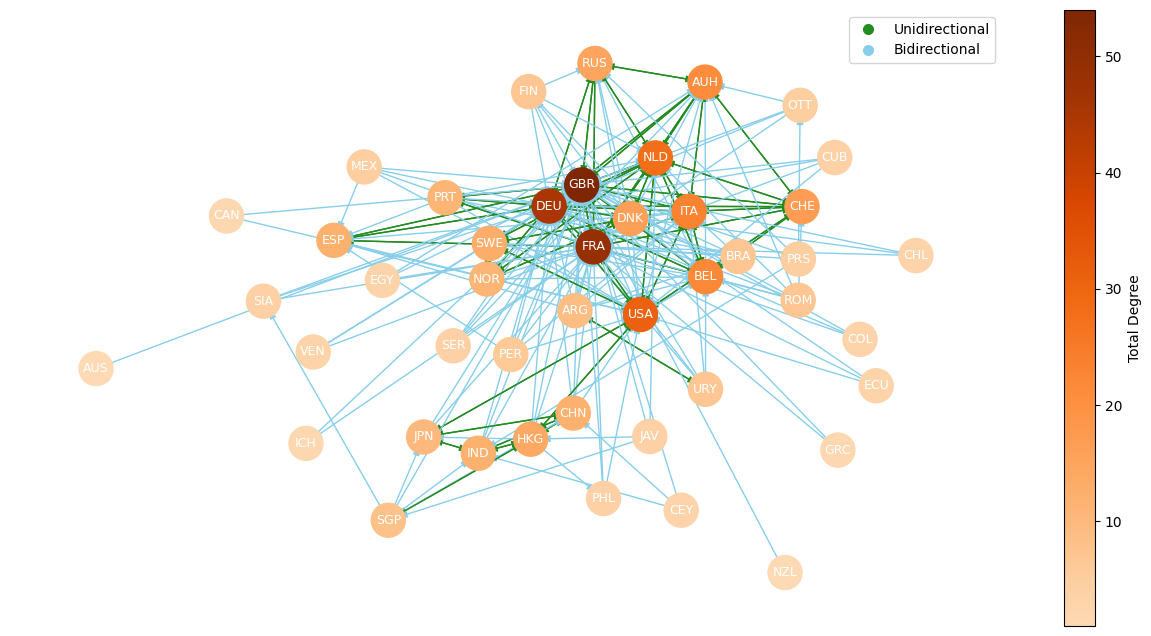

In [26]:
def truncate_colormap(cmap_name, min_val=0.2, max_val=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc", cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

trunc_oranges = truncate_colormap("Oranges", 0.2, 1.0)

# Determine edge colors
edge_colors = []
for u, v in graph_change_1910.edges():
    if graph_change_1910.has_edge(v, u):
        edge_colors.append("forestgreen")  # reciprocal
    else:
        edge_colors.append("skyblue")  # unidirectional

# Compute node colors based on total degree (in-degree + out-degree)
degrees = dict(graph_change_1910.degree())
node_colors = [degrees[node] for node in graph_change_1910.nodes()]

# Draw graph
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(graph_change_1910, seed=43)

nodes = nx.draw_networkx_nodes(
    graph_change_1910,
    pos,
    node_size=600,
    node_color=node_colors,
    cmap=trunc_oranges)

edges = nx.draw_networkx_edges(
    graph_change_1910,
    pos,
    edge_color=edge_colors)

labels = nx.draw_networkx_labels(graph_change_1910, pos, font_size=9, font_color="white")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=9, label='Unidirectional'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=9, label='Bidirectional')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.colorbar(nodes, label="Total Degree")
plt.axis("off")
plt.show()

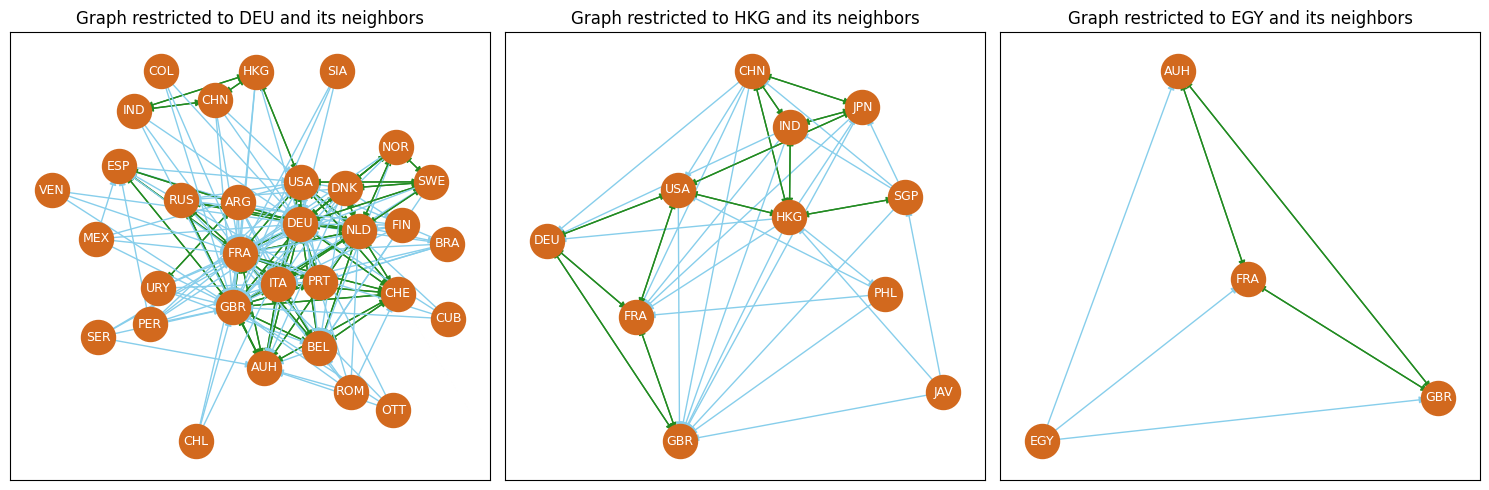

In [27]:
countries = ["DEU", "HKG", "EGY"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, country_B in enumerate(countries):
    # Get the nodes related to country_B
    neighbors = list(graph_change_1910.neighbors(country_B))
    predecessors = list(graph_change_1910.predecessors(country_B))
    nodes_involved = [country_B] + neighbors + predecessors
    subgraph = graph_change_1910.subgraph(nodes_involved)
    restricted_graph = nx.DiGraph(subgraph)

    edge_colors = []
    for u, v in restricted_graph.edges():
        if restricted_graph.has_edge(v, u):
            edge_colors.append("forestgreen")  # reciprocal
        else:
            edge_colors.append("skyblue")  # unidirectional

    pos = nx.spring_layout(restricted_graph)
    ax = axes[i]
    nx.draw_networkx_nodes(restricted_graph, pos, node_size=600, node_color="chocolate", ax=ax)
    nx.draw_networkx_edges(restricted_graph, pos, edge_color=edge_colors, ax=ax)
    nx.draw_networkx_labels(restricted_graph, pos, font_size=9, font_color="white", ax=ax)
    ax.set_title(f"Graph restricted to {country_B} and its neighbors")

plt.tight_layout()
plt.show()

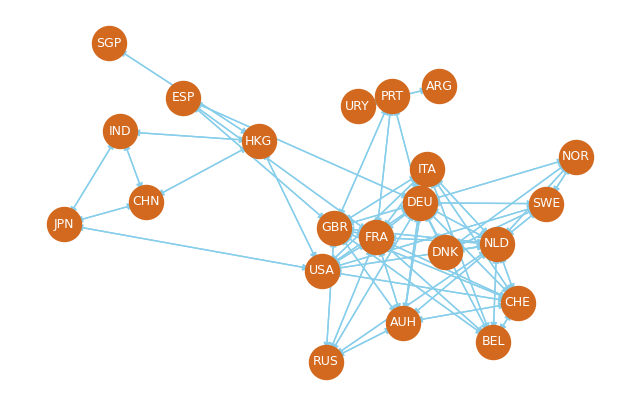

In [28]:
graph_change_1910 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1910"] == 1:
        graph_change_1910.add_edge(row["country_A"], row["country_B"])

# Filter for reciprocal edges
reciprocal_edges = [(u, v) for u, v in graph_change_1910.edges() if graph_change_1910.has_edge(v, u)]
# Get nodes involved in reciprocal edges
nodes_with_reciprocal_edges = set(u for u, v in reciprocal_edges) | set(v for u, v in reciprocal_edges)

plt.figure(figsize=(8, 5))
pos = nx.spring_layout(graph_change_1910, seed=42)
graph_filtered = graph_change_1910.subgraph(nodes_with_reciprocal_edges)

nx.draw_networkx_nodes(graph_filtered, pos, node_size=600, node_color="chocolate")
nx.draw_networkx_edges(graph_filtered, pos, edgelist=reciprocal_edges, edge_color="skyblue")
nx.draw_networkx_labels(graph_filtered, pos, font_size=9, font_color="white")

plt.axis("off")
plt.show()

In [29]:
out_degree = graph_change_1910.out_degree()
in_degree = graph_change_1910.in_degree()

out_degree_centrality = nx.out_degree_centrality(graph_change_1910)
in_degree_centrality = nx.in_degree_centrality(graph_change_1910)
betweenness_centrality = nx.betweenness_centrality(graph_change_1910)
eigenvector_centrality = nx.eigenvector_centrality(graph_change_1910)

df = pd.DataFrame({
    "Country": [node for node, _ in out_degree],
    "Out-Degree": [degree for _, degree in out_degree],
    "In-Degree": [degree for _, degree in in_degree],
    "Out-Degree Centrality": [out_degree_centrality.get(node, 0) for node, _ in out_degree],
    "In-Degree Centrality": [in_degree_centrality.get(node, 0) for node, _ in in_degree],
    "Betweenness Centrality": [betweenness_centrality.get(node, 0) for node, _ in out_degree],
    "Eigenvector Centrality": [eigenvector_centrality.get(node, 0) for node, _ in out_degree]
})

df["In / Out ratio"] = df["In-Degree Centrality"] / df["Out-Degree Centrality"]
df = df[[*df.columns[:df.columns.get_loc("In-Degree Centrality")+1], "In / Out ratio", *df.columns[df.columns.get_loc("In-Degree Centrality")+1:].drop("In / Out ratio")]]

df_sorted = df.sort_values(by="Betweenness Centrality", ascending=False)
df_sorted.style.hide(axis="index").format({
    "Out-Degree": "{:.0f}",
    "In-Degree": "{:.0f}",
    "Out-Degree Centrality": "{:.3f}",
    "In-Degree Centrality": "{:.3f}",
    "Betweenness Centrality": "{:.3f}",
    "Average Centrality": "{:.3f}",
    "In / Out ratio": "{:.3f}",
    "Eigenvector Centrality": "{:.3f}",
})

Country,Out-Degree,In-Degree,Out-Degree Centrality,In-Degree Centrality,In / Out ratio,Betweenness Centrality,Eigenvector Centrality
USA,12,19,0.273,0.432,1.583,0.153,0.232
DEU,14,31,0.318,0.705,2.214,0.101,0.354
HKG,9,5,0.205,0.114,0.556,0.088,0.027
GBR,10,44,0.227,1.000,4.400,0.081,0.357
FRA,11,38,0.250,0.864,3.455,0.078,0.357
NLD,12,16,0.273,0.364,1.333,0.034,0.335
DNK,12,4,0.273,0.091,0.333,0.024,0.097
SGP,6,2,0.136,0.045,0.333,0.024,0.003
JPN,5,5,0.114,0.114,1.000,0.020,0.030
ITA,9,14,0.205,0.318,1.556,0.009,0.288


Du coup en première approche onauqna même de vraies évolutions, avec le développement d'un marché / d'une clique secondaire en Asie, qui finit par fusionner, la place très croissante des USA (d'ailleurs faudra regarder en détail ce qu'il se passe du côte de la Betweeness Centrality, voir comment on peut expliquer cela). Mais il y a sans doute là de quoi faire un travail déjà...

# Seconde approche
***Expliquer la structure du graph avec les attributs ?***

Intéger les relations commerciales (avec `bitrade`) et financières (avec `rshort`et `rlong`) ? Par exemple, est-ce que l'absence de liens entre pays reflète la faiblesse des échanges commerciaux, ou des différentiels de taux d'intérêt ?

Pour les colonnies : aucun pays Africain dans la base

In [30]:
# Ajoutons les attributs
attributesdata = attributes.set_index('country').to_dict('index').items()
graph_change_1900.add_nodes_from(attributesdata)

print(nx.get_node_attributes(graph_change_1900, 'gold'))

{'Argentina': 1, 'United Arab Emirates': 1, 'Australia': 1, 'Belgium': 1, 'Brazil': 0, 'Canada': 1, 'Ceylon': 1, 'Switzerland': 1, 'Chile': 0, 'China': 0, 'Colombia': 0, 'Cuba': 0, 'Germany': 1, 'Denmark': 1, 'Ecuador': 1, 'Egypt': 1, 'Spain': 0, 'Finland': 1, 'France': 1, 'United Kingdom': 1, 'Greece': 0, 'Hong Kong': 0, 'Sandwich Islands': 0, 'India': 1, 'Italy': 0, 'Java': 0, 'Japan': 1, 'Mexico': 0, 'Netherlands': 1, 'Norway': 1, 'New Zealand': 1, 'Ottoman Empire': 1, 'Peru': 0, 'Philippines': 0, 'Persia': 0, 'Portugal': 0, 'Romania': 1, 'Russia': 1, 'Serbia': 1, 'Singapore': 0, 'Siam': 0, 'Sweden': 1, 'Uruguay': 1, 'United States': 1, 'Venezuela': 0}


Nombre de sommets : 16
Nombre d'arêtes : 12


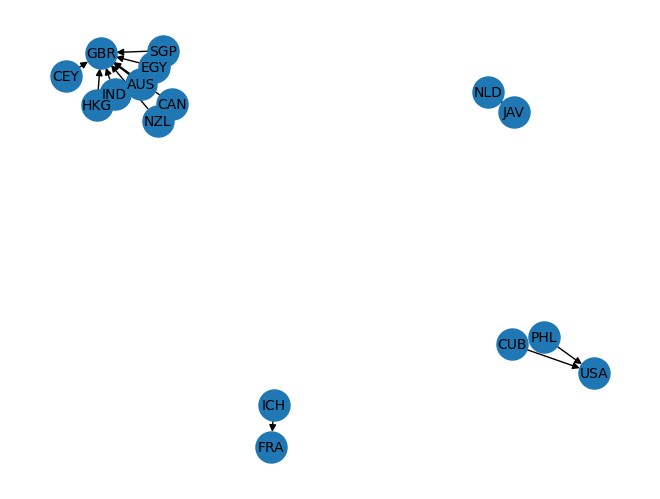

In [31]:
# Création d'un graph des colonies 
graph_colony = nx.DiGraph()

for _, row in data.iterrows():
    if row["colony"] == 1:
        graph_colony.add_edge(row["country_A"], row["country_B"])

print(f"Nombre de sommets : {graph_colony.number_of_nodes()}")
print(f"Nombre d'arêtes : {graph_colony.number_of_edges()}")

nx.draw(graph_colony, with_labels=True, node_size=500, font_size=10)
plt.show()

# Bon par contre ça c'est vraiment un tout petit graph, on a très peu de colonies en fait. Ou plus exactement sans doute, peu de colonies qui ont un marché des changes

## Régressions

Deux approches possibles :
- Régressions **binomiales** sur les liens directionnels
- Régressions **multinomiales** sur les liens bidirectionnels

### Binomiales

In [32]:
# Convert attributes so they qualify directed edges
data['r_short_diff'] = data['rshort1900'] - data['rshort1900_B']
data['r_long_diff'] = data['rlong'] - data['rlong_B']
data['gdp_ratio'] = data['rgdp'] - data['rgdp_B']
data['gold_A_only'] = ((data['gold'] == 1) & (data['gold_B'] == 0)).astype(int)
data['gold_B_only'] = ((data['gold'] == 0) & (data['gold_B'] == 1)).astype(int)
data['gold_both'] = ((data['gold'] == 1) & (data['gold_B'] == 1)).astype(int)
data['gold_none'] = ((data['gold'] == 0) & (data['gold_B'] == 0)).astype(int)

# Replace missing values by 0 for differential interest rates
data.fillna({'r_short_diff': 0, 'r_long_diff': 0}, inplace=True)

# Define and fit the model
formula = 'quote1900 ~ dist + bitrade + colony + r_short_diff + r_long_diff + gdp_ratio + gold_A_only + gold_B_only + gold_both'
model = smf.logit(formula, data=data).fit(cov_type='HC1')

Optimization terminated successfully.
         Current function value: 0.187496
         Iterations 8


In [33]:
# Add OR to the results
table0 = model.summary().tables[0]
table1 = model.summary().tables[1]

results = table1.data
headers = results[0]
rows = results[1:]
exp_coef = [f"{np.exp(float(row[1])):.4f}" for row in rows]
headers.insert(2, 'OR')
new_rows = [row[:2] + [exp] + row[2:] for row, exp in zip(rows, exp_coef)]
new_table1 = SimpleTable(new_rows, headers, txt_fmt=default_txt_fmt)

table0_lines = table0.as_text().splitlines()
table1_lines = new_table1.as_text().splitlines()
if table1_lines[0].startswith('='):
    table1_lines = table1_lines[1:]

full_summary = "\n".join(table0_lines + table1_lines)
print(full_summary)

                           Logit Regression Results                           
Dep. Variable:              quote1900   No. Observations:                 1980
Model:                          Logit   Df Residuals:                     1970
Method:                           MLE   Df Model:                            9
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.4592
Time:                        11:47:47   Log-Likelihood:                -371.24
converged:                       True   LL-Null:                       -686.52
Covariance Type:                  HC1   LLR p-value:                5.779e-130
                coef        OR     std err      z     P>|z|    [0.025    0.975] 
--------------------------------------------------------------------------------
   Intercept     7.0602 1164.6781     0.908     7.777  0.000     5.281     8.839
        dist    -1.2533    0.2856     0.104   -12.024  0.000    -1.458    -1.049
     bitrade  7.289e-06    1.0000  2.88e-06 

Interprétation : outcome = 1 si la monnaie du pays B est échangée localement dans le pays A, 0 sinon

Variables significatives :
- Effet négatif
    - Distance entre A et B => plus A est éloigné de B et moins il est susceptible d'échanger localement sa monnaie
    - Ratio des PIB => plus le PIB de A est élevé relativement à celui de B, moins A est susceptible d'échanger localement la monnaie de B (la variable est égale à log(PIB_A/PIB_B))
- Effet positif
    - Statut colonial => A est plus susceptible d'échanger localement la monnaie de B s'il est une colonie de B
    - Différentiel de taux d'intérêt à CT => A est plus susceptible d'échanger localement la monnaie de B si son taux d'intérêt à CT est supérieur à celui de B
- Effet neutre / pas d'effet
    - Echanges commerciaux, avec un OR quasi-égal à 1
    - Convertibilité en or

### Multinomiales
#### Update the dataset to reflect directed attributes of the edges

In [34]:
data['pair_key'] = data.apply(lambda row: tuple(sorted([row['country_A'], row['country_B']])), axis=1)

def compute_combined_features(group):
    a, b = group['pair_key'].iloc[0]

    a_to_b = group[(group['country_A'] == a) & (group['country_B'] == b)]
    b_to_a = group[(group['country_A'] == b) & (group['country_B'] == a)]

    a_to_b_quote = a_to_b['quote1900'].iloc[0] if not a_to_b.empty else 0
    b_to_a_quote = b_to_a['quote1900'].iloc[0] if not b_to_a.empty else 0

    if a_to_b_quote == 1 and b_to_a_quote == 1:
        currency_market = 3  # or 2 to distinguish only between unidirectional and bidirectional links, their direction not withstanding
    elif a_to_b_quote == 1:
        currency_market = 1
    elif b_to_a_quote == 1:
        currency_market = 2  # or 1 for the same reason
    else:
        currency_market = 0

    a_to_b_colony = a_to_b['colony'].iloc[0] if not a_to_b.empty else 0
    b_to_a_colony = b_to_a['colony'].iloc[0] if not b_to_a.empty else 0

    if a_to_b_colony == 1 and b_to_a_colony == 1:
        colony_status = 3
    elif a_to_b_colony == 1:
        colony_status = 1
    elif b_to_a_colony == 1:
        colony_status = 2
    else:
        colony_status = 0

    a_to_b_gold = a_to_b['gold'].iloc[0] if not a_to_b.empty else 0
    b_to_a_gold = b_to_a['gold'].iloc[0] if not b_to_a.empty else 0

    if a_to_b_gold == 1 and b_to_a_gold == 1:
        gold_status = 3
    elif a_to_b_gold == 1:
        gold_status = 1
    elif b_to_a_gold == 1:
        gold_status = 2
    else:
        gold_status = 0
    
    dist_value = group['dist'].iloc[0]
    bitrade_value = group['bitrade'].iloc[0]

    # Retain all extra variables from the A->B row if available
    extra_columns = ['r_short_diff', 'r_long_diff', 'gdp_ratio']
    
    extras = {}
    if not a_to_b.empty:
        for col in extra_columns:
            extras[col] = a_to_b[col].iloc[0]
    else:
        # If no A->B row exists, fill with NaN
        for col in extra_columns:
            extras[col] = pd.NA

    return pd.Series({
        'country_A': a,
        'country_B': b,
        'currency_market': currency_market,
        'colony': colony_status,
        'gold': gold_status,
        'dist': dist_value,
        'bitrade': bitrade_value,
        **extras
    })

# Apply groupby
synthetic_data = data.groupby('pair_key').apply(compute_combined_features).reset_index(drop=True)
synthetic_data['currency_market'] = synthetic_data['currency_market'].astype('category')
synthetic_data['colony'] = synthetic_data['colony'].astype('category')
synthetic_data['gold'] = synthetic_data['gold'].astype('category')

/tmp/ipykernel_1171/2127431410.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  synthetic_data = data.groupby('pair_key').apply(compute_combined_features).reset_index(drop=True)


#### Consistency check for a given row

In [35]:
synthetic_data[(synthetic_data['currency_market']==1) & (synthetic_data['colony']==1)].head(1).style.hide(axis="index")

country_A,country_B,currency_market,colony,gold,dist,bitrade,r_short_diff,r_long_diff,gdp_ratio
AUS,GBR,1,1,3,9.735524,1134737.000000,1.560000,0.570000,-2.510750


In [36]:
# Values in the original df are identical
data[(data['country_A']=='AUS') & (data['country_B']=='GBR')].style.hide(axis="index")

country_A,country_B,quote1890,quote1900,quote1910,colony,dist,bitrade,gold,debtburden,rlong,rshort1900,rshort1890,rgdp,rgdpcap,poldemo,coverage,gold_B,debtburden_B,rlong_B,rshort1900_B,rshort1890_B,rgdp_B,rgdpcap_B,poldemo_B,r_short_diff,r_long_diff,gdp_ratio,gold_A_only,gold_B_only,gold_both,gold_none,pair_key
AUS,GBR,1,1,1,1,9.735524,1134737.000000,1,6.065920,3.120000,5.500000,7.000000,16.524400,8.297290,6.370000,0.000000,1,5.028125,2.550000,3.940000,4.520000,19.035150,8.410050,3.680000,1.560000,0.570000,-2.510750,0,0,1,0,"('AUS', 'GBR')"


In [37]:
# The symetric pair does not exist
synthetic_data[(synthetic_data['country_A']=='GBR') & (synthetic_data['country_B']=='AUS')]

,country_A,country_B,currency_market,colony,gold,dist,bitrade,r_short_diff,r_long_diff,gdp_ratio


#### Fit the model
Statsmodels does not handle categorical variables natively...

In [38]:
# Create dummies for categorical variables
## Colony, the reference being no country of the pair is a colony of the other
## Must be excluded from the model, which does not fit otherwise. Indeed, colony is ≠ 0 for only 12 observations out of 990.
# colony_dummies = pd.get_dummies(synthetic_data['colony'], prefix='colony', drop_first=True).astype(int)
## Gold, the reference being no country of the pair adheres to the gold standard
gold_dummies = pd.get_dummies(synthetic_data['gold'], prefix='gold', drop_first=True).astype(int)

# Build the dataset
continuous_data = synthetic_data[['dist', 'bitrade', 'r_short_diff', 'r_long_diff', 'gdp_ratio']]
independent_variables = pd.concat([continuous_data, gold_dummies], axis=1)
dependent_variable = synthetic_data['currency_market']

# Define and fit the model
model = sm.MNLogit(dependent_variable, independent_variables).fit(cov_type='HC1')
model.summary()

Optimization terminated successfully.
         Current function value: 0.303911
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:        currency_market   No. Observations:                  990
Model:                        MNLogit   Df Residuals:                      966
Method:                           MLE   Df Model:                           21
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.5307
Time:                        11:47:49   Log-Likelihood:                -300.87
converged:                       True   LL-Null:                       -641.05
Covariance Type:                  HC1   LLR p-value:                1.870e-130
=====================================================================================
currency_market=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dist                 -0.7354      0.093     -7.887      0.000      -0.918      -0.553
bitrade            3.491e-05   5.26e-06      6.640      0.000    2.46e-05    4.52e-05
r_short_diff          0.6460      0.151      4.278      0.000       0.350       0.942
r_long_diff          -0.0998      0.119     -0.836      0.403      -0.334       0.134
gdp_ratio            -0.6526      0.163     -4.010      0.000      -0.972      -0.334
gold_1                1.4328      0.927      1.545      0.122      -0.385       3.250
gold_2                0.6499      0.820      0.793      0.428      -0.956       2.256
gold_3                0.5505      0.810      0.680      0.497      -1.037       2.138
-------------------------------------------------------------------------------------
currency_market=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dist                 -0.5153      0.067     -7.644      0.000      -0.647      -0.383
bitrade             3.69e-05    5.1e-06      7.230      0.000    2.69e-05    4.69e-05
r_short_diff         -0.3137      0.079     -3.946      0.000      -0.469      -0.158
r_long_diff          -0.1129      0.059     -1.922      0.055      -0.228       0.002
gdp_ratio             0.4404      0.103      4.281      0.000       0.239       0.642
gold_1                0.0485      0.521      0.093      0.926      -0.972       1.069
gold_2               -3.0127      1.547     -1.948      0.051      -6.044       0.019
gold_3               -0.1427      0.542     -0.263      0.792      -1.205       0.920
-------------------------------------------------------------------------------------
currency_market=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
dist                 -0.9136      0.334     -2.734      0.006      -1.569      -0.259
bitrade            3.773e-05   5.17e-06      7.292      0.000    2.76e-05    4.79e-05
r_short_diff         -0.0338      0.114     -0.295      0.768      -0.258       0.191
r_long_diff          -0.0042      0.119     -0.035      0.972      -0.238       0.229
gdp_ratio             0.2235      0.137      1.632      0.103      -0.045       0.492
gold_1                2.9069      2.773      1.048      0.294      -2.527       8.341
gold_2                1.7463      2.895      0.603      0.546      -3.928       7.421
gold_3                2.8715      2.623      1.095      0.274      -2.270       8.013
=====================================================================================
"""

Interprétation : outcome = 1 si la monnaie du pays B est échangée localement dans le pays A, 2 pour l'inverse, 3 si A et B échangent localement leur monnaie, 0 si aucun des deux n'échange localement la monnaie de l'autre (modalité de référence)

On retrouve à peu près les mêmes variables significatives avec des effets de même signe.
- L'effet de la convertibilité en or devient significatif à 10 % lorsque la monnaie du pays échangeant localement celle de l'autre est convertible en or (gold = 1 si seule la monnaie du pays A est convertible, 2 si seule la monnaie du pays B est convertible, 3 lorsque les deux monnaies sont convertibles, 0 sinon).
- L'effet du différentiel de taux d'intérêt à CT disparaît sur la probabilité que deux pays échangent mutuellement leur monnaie.


*Il est aussi possible de fusionner les modalités 1 et 2 pour comparer seulement l'absence de lien à l'existence de liens unilatéraux ou bilatéraux, sans considérer leur direction. Les différentiels de taux d'intérêt et de PIB ne sont plus significatifs : reste seulement la distance, le volume du commerce (mais avec un coefficient toujours nul) et la convertibilité en or (avec un effet massif, OR de l'ordre de 20).*